# New York Taxi Fare Prediction

Can you predict a rider's taxi fare?

Kaggle: https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/overview

Project outline:
1. Download/ Load the dataset
2. Explore & analyze the dataset
3. Prepare the dataset for ML training
4. Train hardcoded & baseline models
5. Make predictions & submit to Kaggle
6. Perform feature engineering
7. Train & evaluate different models
8. Tune hyperparameters for the best models
9. Train on a GPU with the entire dataset

## 1. Download/ Load the dataset

Steps:
* Install required libraries
* Download data from Kaggle
* View dataset files
* Load training set in dataframe
* Load test set in dataframe

In [1]:
# Import time package
import time

### View Dataset Files

#### Use Shell commands to view the large dataset

In [2]:
# set path of the directory
data_dir = './'

In [3]:
# List of files with size from directory
!ls -lh {data_dir}

total 11204840
-rw-r--r--@ 1 robot  staff   486B Jul  5 11:52 GCP-Coupons-Instructions.rtf
-rw-r--r--  1 robot  staff   373K Jul 12 17:12 linear_model_submission.csv
-rw-r--r--  1 robot  staff   373K Jul 12 16:23 linear_sub2.csv
-rw-r--r--  1 robot  staff   373K Jul 12 17:12 linreg_submission.csv
-rw-r--r--  1 robot  staff   229K Jul 12 17:13 ny-taxi-fare-prediction.ipynb
-rw-------@ 1 robot  staff   274K Jul 12 17:03 nyc_taxi_fare_prediction.ipynb
-rw-r--r--  1 robot  staff   454K Jul 12 07:50 rf_submission.csv
-rw-r--r--  1 robot  staff   454K Jul 12 17:08 ridge_submission.csv
-rw-r--r--@ 1 robot  staff   335K Jul  5 11:52 sample_submission.csv
-rw-r--r--@ 1 robot  staff   960K Jul  5 11:51 test.csv
-rw-r--r--  1 robot  staff   652K Jul 12 17:12 test.parquet
-rw-rw-r--@ 1 robot  staff   5.3G Dec 12  2019 train.csv
-rw-r--r--  1 robot  staff    25M Jul 12 17:12 train.parquet
-rw-r--r--  1 robot  staff   7.0M Jul 12 17:12 val.parquet
-rw-r--r--  1 robot  staff   369K Jul 12 07:50 xgb_s

In [4]:
# Load Training set
!head {data_dir}/train.csv

In [5]:
# Load Test set
!head {data_dir}/test.csv

In [6]:
# Load Sample submission file
!head {data_dir}/sample_submission.csv

key,fare_amount
2015-01-27 13:08:24.0000002,11.35
2015-01-27 13:08:24.0000003,11.35
2011-10-08 11:53:44.0000002,11.35
2012-12-01 21:12:12.0000002,11.35
2012-12-01 21:12:12.0000003,11.35
2012-12-01 21:12:12.0000005,11.35
2011-10-06 12:10:20.0000001,11.35
2011-10-06 12:10:20.0000003,11.35
2011-10-06 12:10:20.0000002,11.35


In [7]:
# No. of lines in training set
!wc -l {data_dir}/train.csv

 55423856 .//train.csv


In [8]:
# No. of lines in test set
!wc -l {data_dir}/test.csv

    9914 .//test.csv


In [9]:
# No. of lines in submission file
!wc -l {data_dir}/sample_submission.csv

    9915 .//sample_submission.csv


Observation:
* It is a supervised learning regression problem
* Size of training data is 5.5 GB
* Training data has 5.5 million rows
* Test data has < 10000 rows
* Training set has 8 columns:
    * `key` (unique identifier)
    * `fare_amount` (target column)
    * `pickup_datetime`
    * `pickup_longitude`
    * `pickup_latitude`
    * `dropoff_longitude`
    * `dropoff_latitude`
    * `passenger_count`
* Test set does not include target colum `fare_amount`
* Submission file contains `key` and `fare_amount` column for each test data

### Loading Training Set

> Tip: When working with large datasets, always start with a sample to experiment & iterate faster

Loading entire datasets into Pandas is very slow, use the following optimizations:
* Ignore the `key` column
* Parse `pickup_datetime` while loading the data
* Specify data types for other columns
    * `float32` for geo coordinates
    * `float32` for fare 
    * `uint8` for passenger count
* Work with 1% sample data (~500k rows)

In [10]:
# Import packages
import pandas as pd
import random

In [11]:
# set sample fraction of dataset
sample_fraction = 0.01

In [12]:
%time

# defined selected columns
selected_cols = ['fare_amount', 'pickup_datetime', 'pickup_longitude',
                 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

# defined data types
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

# function for selecting random rows of data
def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_fraction

# Set random seed
random.seed(42)

# Load data to a pandas dataframe
df = pd.read_csv(data_dir+'/train.csv', usecols=selected_cols, 
                       parse_dates=['pickup_datetime'], dtype=dtypes, 
                       skiprows=skip_row)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


In [13]:
# show train dataset
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755482,1
1,8.0,2013-01-17 17:22:00+00:00,0.000000,0.000000,0.000000,0.000000,2
2,8.9,2011-06-15 18:07:00+00:00,-73.996330,40.753223,-73.978897,40.766964,3
3,6.9,2009-12-14 12:33:00+00:00,-73.982430,40.745747,-73.982430,40.745747,1
4,7.0,2013-11-06 11:26:54+00:00,-73.959061,40.781059,-73.962059,40.768604,1
...,...,...,...,...,...,...,...
552445,45.0,2014-02-06 23:59:45+00:00,-73.973587,40.747669,-73.999916,40.602894,1
552446,22.5,2015-01-05 15:29:08+00:00,-73.935928,40.799656,-73.985710,40.726952,2
552447,4.5,2013-02-17 22:27:00+00:00,-73.992531,40.748619,-73.998436,40.740143,1
552448,14.5,2013-01-27 12:41:00+00:00,-74.012115,40.706635,-73.988724,40.756218,1


***fix seeds for random number generators, so that we can get same results everytime we run the notebook.***

### Load Test Set

Update data types and parse datetime.

In [14]:
# load test dataset
test_df = pd.read_csv(data_dir+'/test.csv', dtype=dtypes, parse_dates=['pickup_datetime'])

In [15]:
# show test dataset
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6


## 2. Explore & Analyze Dataset

* Basic info about training set
* Basic info about test set
* Exploratory data analysis & visualization
* Ask and answer questions

### Training Set

In [16]:
# show train set information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float32            
 6   passenger_count    552450 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 15.3 MB


In [17]:
# show summary statistics of train set
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910500,-72.504326,39.934265,1.684983
std,9.811924,11.618246,8.061114,12.074346,9.255057,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


In [18]:
# show datetime ranges
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2009-01-01 00:11:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

Observations about training data:
* 550K+ rows
* No missing data in sample data
* `fare_amount` ranges from `$-52.0` to `$499.0`
* `passenger_count` ranges from 0 to 208
* There are errors in longitude and latitude values (outliers are there)
* `pickup_datetime` ranges from 1st Jan 2009 to 30th June 2015
* Sample data takes memory up to ~16MB in RAM

***We may need to deal with outliers and data entry error before training ML model***

### Test Set

In [19]:
# show test set information
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


In [20]:
# show summary statistics of test set
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


In [21]:
# show datetime ranges
test_df['pickup_datetime'].min(), test_df['pickup_datetime'].max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

Observations about test set:
* 9914 rows of data
* No missing values
* No obvious data entry errors
* `passenger_count` ranges between 1 to 6 passengers (we can limit trianing data to this range)
* Latitude lies between 40 and 42
* Longitude lies between -74 and -73
* `pickup_datetime` ranges from 1st Jan 2009 to 30th June 2015 (same as training set)

***We can use this ranges of the test set to drop outliers/ invalid data from training set.***

### Exploratory Data Analysis and Visualization

**Tasks**: Create graphs (histograms, line charts, bar charts, scatter plots, box plots, geo maps etc.) to study the distribution of values in each column, and the relationship of each input column to the target.

### Ask & Answer Questions

Questions:
1. What is the busiest day of the week?
2. What is the busiest time of the day?
3. In which month are fares the highest?
4. Which pickup locations have the highest fares?
5. Which drop locations have the highest fares?
6. What is the average ride distance?

> Understanding the data using EDA will give ideas for feature engineering.

> Iterative approach building ML models: do some EDA, do some feature engineering, train a model, repeat to improve the model.

## 3. Prepare Dataset for ML Training

* Split Training & Validation Set
* Fill/ Remove Missing Values
* Extract Inputs & Outputs
    * Training 
    * Validation
    * Test

### Split Training & Validation Set

Set aside 20% of training data as validation set, to evaluate the train models. Pick random 20% fraction as test set and training set have same date ranges .

> TIP: Validation set should be similar to test set or real world data as close as possible, i.e. evaluation score of a model on validation & test sets should be very close.

In [22]:
# Import package from sklearn for splitting data
from sklearn.model_selection import train_test_split

In [23]:
# split data into train and validation set
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [24]:
# check row count
len(train_df), len(val_df)

(441960, 110490)

### Fill/ Remove Missing Values

There were no missing values in sample data, but if there were, we will drop the rows with missing values instead of trying to fill them (since we have lot of training data)

In [25]:
# drop missing values
train_df = train_df.dropna()
val_df = val_df.dropna()

### Extract Inputs and Outputs

In [26]:
# list all columns
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [27]:
# defined input columns
input_cols = ['pickup_longitude', 'pickup_latitude',
              'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

# defined target column
target_col = 'fare_amount'

### Training Inputs

In [28]:
# get training inputs data
train_inputs = train_df[input_cols]

In [29]:
# get training target data
train_targets = train_df[target_col]

In [30]:
# show train inputs data
train_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
353352,-73.993652,40.741543,-73.977974,40.742352,4
360070,-73.993805,40.724579,-73.993805,40.724579,1
372609,-73.959160,40.780750,-73.969116,40.761230,1
550895,-73.952187,40.783951,-73.978645,40.772602,1
444151,-73.977112,40.746834,-73.991104,40.750404,2
...,...,...,...,...,...
110268,-73.987152,40.750633,-73.979073,40.763168,1
259178,-73.972656,40.764042,-74.013176,40.707840,2
365838,-73.991982,40.749767,-73.989845,40.720551,3
131932,-73.969055,40.761398,-73.990814,40.751328,1


In [31]:
# show train target data
train_targets

353352     6.0
360070     3.7
372609    10.0
550895     8.9
444151     7.3
          ... 
110268     9.3
259178    18.5
365838    10.1
131932    10.9
121958     9.5
Name: fare_amount, Length: 441960, dtype: float32

### Validation Inputs

In [32]:
# get validation inputs data
val_inputs = val_df[input_cols]

In [33]:
# get validation target data
val_targets = val_df[target_col]

In [34]:
# show validation inputs data
val_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
15971,-73.995834,40.759190,-73.973679,40.739086,1
149839,-73.977386,40.738335,-73.976143,40.751205,1
515867,-73.983910,40.749470,-73.787170,40.646645,1
90307,-73.790794,40.643463,-73.972252,40.690182,1
287032,-73.976593,40.761944,-73.991463,40.750309,2
...,...,...,...,...,...
467556,-73.968567,40.761238,-73.983406,40.750019,3
19482,-73.986725,40.755920,-73.985855,40.731171,1
186063,0.000000,0.000000,0.000000,0.000000,1
382260,-73.980057,40.760334,-73.872589,40.774300,1


In [35]:
# show validation target data
val_targets

15971     14.000000
149839     6.500000
515867    49.570000
90307     49.700001
287032     8.500000
            ...    
467556     6.100000
19482      7.300000
186063     4.500000
382260    32.900002
18838     11.500000
Name: fare_amount, Length: 110490, dtype: float32

### Test Inputs

It will not have target data, which we have to predict.

In [36]:
# get test inputs data
test_inputs = test_df[input_cols]

In [37]:
# show test target data
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746140,1
3,-73.981163,40.767807,-73.990448,40.751637,1
4,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6
9910,-73.945511,40.803600,-73.960213,40.776371,6
9911,-73.991600,40.726608,-73.789742,40.647011,6
9912,-73.985573,40.735432,-73.939178,40.801731,6


## 4. Train Hardcoded & Baseline models

> TIP: Always create a simple hardcoded or baseline model to establish the minimum score any proper ML model should beat.

* Hardcoded model: always predict average fare
* Baseline model: Linear regression

### Train & Evaluate Hardcoded Model

Create a simple model that always predict the average.

In [38]:
# Import numpy package
import numpy as np

In [39]:
# create a class for training and predicting average
class MeanRegressor:
    def fit(self, inputs, targets):
        self.mean = targets.mean()
    
    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)

In [40]:
# Instatiate the model
mean_model = MeanRegressor()

In [41]:
# Use fit function from class
mean_model.fit(train_inputs, train_targets)

In [42]:
# get the mean from the model
mean_model.mean

11.354714

In [43]:
# predict the mean from model using train set
train_preds = mean_model.predict(train_inputs)

In [44]:
# show prediction results on train set
train_preds

array([11.354714, 11.354714, 11.354714, ..., 11.354714, 11.354714,
       11.354714], dtype=float32)

In [45]:
# show actual targets from train set
train_targets

353352     6.0
360070     3.7
372609    10.0
550895     8.9
444151     7.3
          ... 
110268     9.3
259178    18.5
365838    10.1
131932    10.9
121958     9.5
Name: fare_amount, Length: 441960, dtype: float32

In [46]:
# predict the mean from model using validation set
val_preds = mean_model.predict(val_inputs)

In [47]:
# show prediction results on validation set
val_preds

array([11.354714, 11.354714, 11.354714, ..., 11.354714, 11.354714,
       11.354714], dtype=float32)

In [48]:
# show actual targets from validation set
val_targets

15971     14.000000
149839     6.500000
515867    49.570000
90307     49.700001
287032     8.500000
            ...    
467556     6.100000
19482      7.300000
186063     4.500000
382260    32.900002
18838     11.500000
Name: fare_amount, Length: 110490, dtype: float32

In [49]:
# Import metrics packages from sklearn
from sklearn.metrics import mean_squared_error

In [50]:
# define a function to calculate mean squared error
def rmse(targets, preds):
    return mean_squared_error(targets, preds, squared=False)

In [51]:
# calculate train loss (mean squared error)
train_rmse = rmse(train_targets, train_preds)
train_rmse

9.789782

In [52]:
# calculate validation loss (mean squared error)
val_rmse = rmse(val_targets, val_preds)
val_rmse

9.899954

Hard-coded model is off by `$9.899` on average, which is pretty bad considering average fare is `$11.35`

### Train & Evaluate Baseline Model

Train a linear regression model as our baseline model, which tries to express the target as weighted sum of the inputs.

In [53]:
# Import linear regression package from sklearn
from sklearn.linear_model import LinearRegression

In [54]:
# Instantiate the linear regression
linear_model = LinearRegression()

In [55]:
# Fit the model to training data
linear_model.fit(train_inputs, train_targets)

LinearRegression()

In [56]:
# make prediction on training data
train_preds = linear_model.predict(train_inputs)

In [57]:
# show prediction on training data
train_preds

array([11.546237, 11.28461 , 11.28414 , ..., 11.458918, 11.284281,
       11.284448], dtype=float32)

In [58]:
# calculate training loss (root mean squared error)
rmse(train_targets, train_preds)

9.788632

In [59]:
# make prediction on validation data
val_preds = linear_model.predict(val_inputs)

In [60]:
# show prediction on validation data
val_preds

array([11.284328 , 11.284496 , 11.2847805, ..., 11.8045   , 11.284433 ,
       11.284133 ], dtype=float32)

In [61]:
# calculate validation loss (root mean squared error)
rmse(val_targets, val_preds)

9.898088

Linear regression model is off by `$9.899`, which isn't much better than simply predicting the average.

This is mainly because, training data(geocoordinates) is not in a format that is useful for the model, we are also not using most important columm `pickup_datetime`

Now, proper model should beat the baseline model.

## 5. Make Predictions & Submit to Kaggle

* Make predictions for test set
* Generate submissions CSV
* Submit to Kaggle
* Record in experiment tracking sheet

In [62]:
# show test inputs
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746140,1
3,-73.981163,40.767807,-73.990448,40.751637,1
4,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6
9910,-73.945511,40.803600,-73.960213,40.776371,6
9911,-73.991600,40.726608,-73.789742,40.647011,6
9912,-73.985573,40.735432,-73.939178,40.801731,6


In [63]:
# make predictions on test data
test_preds = linear_model.predict(test_inputs)

In [64]:
# show prediction results on test data
test_preds

array([11.28428  , 11.284634 , 11.284384 , ..., 11.721249 , 11.7207985,
       11.720594 ], dtype=float32)

In [65]:
# load sample submission data
submission_df = pd.read_csv(data_dir+'/sample_submission.csv')

In [66]:
# show sample submission data
submission_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


Test data and sample submission data has same number of rows and key columns are same in both dataset, so we just need to update the `fare_amount` column with new prediction data.

In [67]:
# now replace the fare_amount with test predictions
submission_df['fare_amount'] = test_preds

In [68]:
# show new sample submission data
submission_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.284280
1,2015-01-27 13:08:24.0000003,11.284634
2,2011-10-08 11:53:44.0000002,11.284384
3,2012-12-01 21:12:12.0000002,11.284223
4,2012-12-01 21:12:12.0000003,11.284050
...,...,...
9909,2015-05-10 12:37:51.0000002,11.720277
9910,2015-01-12 17:05:51.0000001,11.720225
9911,2015-04-19 20:44:15.0000001,11.721249
9912,2015-01-31 01:05:19.0000005,11.720798


In [69]:
# save submission data to CSV
submission_df.to_csv('linear_model_submission.csv', index=None)

In [70]:
# function to create submission file
def generate_submission(test_preds, fname):
    sub_df = pd.read_csv(data_dir+'/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)

In [71]:
# create submission file for linear_model
generate_submission(test_preds, 'linreg_submission.csv')

## 6. Feature Engineering

> TIP: Take an iterative approach to feature engineering. Add some features, train a model, evaluate it, keep the features if they help, otherwise drop them, then repeat.

* Extract parts of date
* Remove outliers & invalid data
* Add distance between pickup & drop
* Add distance from landmarks

### Extract Parts of Date
* Year
* Month
* Day
* Weekday
* Hour

In [72]:
# define a function extract parts from datetime
def add_dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [73]:
# add date parts in train set
add_dateparts(train_df, 'pickup_datetime')

In [74]:
# add date parts in validation set
add_dateparts(val_df, 'pickup_datetime')

In [75]:
# add date parts in test set
add_dateparts(test_df, 'pickup_datetime')

In [76]:
# show train set
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1,2011,1,26,2,19
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1,2012,10,3,2,10
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1,2012,3,14,2,13
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2,2012,2,5,6,15
...,...,...,...,...,...,...,...,...,...,...,...,...
110268,9.3,2009-09-06 16:12:00+00:00,-73.987152,40.750633,-73.979073,40.763168,1,2009,9,6,6,16
259178,18.5,2009-04-12 09:58:56+00:00,-73.972656,40.764042,-74.013176,40.707840,2,2009,4,12,6,9
365838,10.1,2012-07-12 19:30:00+00:00,-73.991982,40.749767,-73.989845,40.720551,3,2012,7,12,3,19
131932,10.9,2011-02-17 18:33:00+00:00,-73.969055,40.761398,-73.990814,40.751328,1,2011,2,17,3,18


In [77]:
# show validation set
val_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
15971,14.000000,2015-05-19 09:27:24+00:00,-73.995834,40.759190,-73.973679,40.739086,1,2015,5,19,1,9
149839,6.500000,2010-04-10 15:07:51+00:00,-73.977386,40.738335,-73.976143,40.751205,1,2010,4,10,5,15
515867,49.570000,2009-07-25 14:11:00+00:00,-73.983910,40.749470,-73.787170,40.646645,1,2009,7,25,5,14
90307,49.700001,2011-11-11 19:09:21+00:00,-73.790794,40.643463,-73.972252,40.690182,1,2011,11,11,4,19
287032,8.500000,2015-03-09 18:06:44+00:00,-73.976593,40.761944,-73.991463,40.750309,2,2015,3,9,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...
467556,6.100000,2010-04-03 20:16:00+00:00,-73.968567,40.761238,-73.983406,40.750019,3,2010,4,3,5,20
19482,7.300000,2010-04-26 00:32:00+00:00,-73.986725,40.755920,-73.985855,40.731171,1,2010,4,26,0,0
186063,4.500000,2009-05-21 08:13:16+00:00,0.000000,0.000000,0.000000,0.000000,1,2009,5,21,3,8
382260,32.900002,2011-07-07 16:10:59+00:00,-73.980057,40.760334,-73.872589,40.774300,1,2011,7,7,3,16


In [78]:
# show test set
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21
...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,10,6,12
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,12,0,17
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,19,6,20
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,31,5,1


### Add Distance Between Pickup and Drop Location

We can use the haversine distance: 
- https://en.wikipedia.org/wiki/Haversine_formula
- https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

In [79]:
# function to calculate distances between two points
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [80]:
# define function to add distance in dataframe
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'], 
                                          df['pickup_latitude'], 
                                          df['dropoff_longitude'], 
                                          df['dropoff_latitude'])

In [81]:
# add trip distance in train set
add_trip_distance(train_df)

In [82]:
# add trip distance in validation set
add_trip_distance(val_df)

In [83]:
# add trip distance in test set
add_trip_distance(test_df)

In [84]:
# show train set
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3,1.323411
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1,2011,1,26,2,19,0.000000
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1,2012,10,3,2,10,2.325504
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1,2012,3,14,2,13,2.558912
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2,2012,2,5,6,15,1.243267


In [85]:
# show validation set
val_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
15971,14.000000,2015-05-19 09:27:24+00:00,-73.995834,40.759190,-73.973679,40.739086,1,2015,5,19,1,9,2.909793
149839,6.500000,2010-04-10 15:07:51+00:00,-73.977386,40.738335,-73.976143,40.751205,1,2010,4,10,5,15,1.433791
515867,49.570000,2009-07-25 14:11:00+00:00,-73.983910,40.749470,-73.787170,40.646645,1,2009,7,25,5,14,20.132486
90307,49.700001,2011-11-11 19:09:21+00:00,-73.790794,40.643463,-73.972252,40.690182,1,2011,11,11,4,19,16.152088
287032,8.500000,2015-03-09 18:06:44+00:00,-73.976593,40.761944,-73.991463,40.750309,2,2015,3,9,0,18,1.799553


In [86]:
# show test set
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,2.321899
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,2.423777
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11,0.618015
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21,1.959681
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21,5.383829


### Add Distance From Popular Landmarks

> TIP: Creative feature engineering (generally involving human insights or external data) is a lot more effective than excessive hyperparameter tuning. Just one or two good feature improve the model's performance drastically.

* JFK Airport
* LGA Airport
* EWR Airport
* Times Square
* Met Meuseum
* World Trade Center

Add distance from drop location. ( **Use distance from pickup location**)

In [87]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

In [88]:
# function to calculate drop location distance from popular landmarks
def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])


In [89]:
# add distance data in dataframe
def add_landmarks(a_df):
    landmarks = [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]
    for name, lonlat in landmarks:
        add_landmark_dropoff_distance(a_df, name, lonlat)

In [90]:
# add drop distance from landmark in train set
add_landmarks(train_df)

In [91]:
# add drop distance from landmark in validation set
add_landmarks(val_df)

In [92]:
# add drop distance from landmark in test set
add_landmarks(test_df)

In [93]:
# show train set
train_df.sample(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
65403,11.300000,2009-04-10 22:21:17+00:00,-73.989716,40.734146,-73.952446,40.780819,1,2009,4,10,4,22,6.061746,21.355486,6.615324,21.274158,0.918872,8.992682
332354,4.900000,2010-05-20 13:50:33+00:00,-73.992210,40.749722,-74.003334,40.732533,1,2010,5,20,3,13,2.127146,21.517233,11.951065,15.190763,6.207408,2.283231
456287,14.500000,2014-10-31 23:25:33+00:00,-73.993080,40.758327,-74.004005,40.737583,1,2014,10,31,4,23,2.481920,21.836344,11.783128,15.322783,5.778199,2.820470
535343,47.330002,2014-10-22 16:54:00+00:00,-73.866005,40.770748,-73.982811,40.764690,1,2014,10,22,2,16,9.853985,22.032621,9.257354,18.177048,2.322720,6.221698
303768,9.300000,2011-07-18 18:35:00+00:00,-74.003349,40.705791,-74.002281,40.729424,3,2011,7,18,0,18,2.627712,21.278175,12.018396,15.170528,6.454662,1.976589


In [94]:
# show validation set
val_df.sample(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
502694,8.5,2009-06-03 18:03:53+00:00,-74.010925,40.701965,-73.989647,40.720383,1,2009,6,3,2,18,2.720791,19.875696,11.585439,15.946467,6.925609,1.912977
208286,7.3,2009-11-10 08:11:18+00:00,-73.970871,40.748474,-73.991554,40.758121,1,2009,11,10,1,8,2.044621,22.179581,10.111270,17.191202,3.359102,5.289378
381369,16.5,2012-06-16 12:35:00+00:00,-73.977692,40.773643,-73.943893,40.835323,6,2012,6,16,5,12,7.420328,25.685757,8.758722,25.285181,6.423449,14.725665
543717,10.1,2010-11-12 01:10:00+00:00,-73.997276,40.722424,-73.958054,40.717529,1,2010,11,12,4,1,3.348216,17.370888,9.674793,18.498436,6.889108,4.401288
287191,19.0,2013-07-23 09:43:22+00:00,-73.975143,40.742115,-74.010750,40.721886,1,2013,7,23,1,9,3.747517,21.554010,13.034655,14.256420,7.541061,1.034331


In [95]:
# show test set
test_df.sample(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
6583,2009-06-13 18:36:47.0000002,2009-06-13 18:36:47+00:00,-73.987312,40.761395,-73.955910,40.773010,1,2009,6,13,5,18,2.941447,20.942211,6.906303,20.614281,0.938609,8.107362
1727,2011-10-04 09:37:00.000000101,2011-10-04 09:37:00+00:00,-73.976967,40.758171,-73.983429,40.749241,1,2011,10,4,1,9,1.131681,21.051355,9.709518,17.408432,3.758893,4.642037
4971,2013-10-13 19:52:54.0000001,2013-10-13 19:52:54+00:00,-73.992592,40.756397,-73.991425,40.750099,1,2013,10,13,6,19,0.706676,21.661686,10.322225,16.825628,4.030168,4.448266
2405,2010-09-20 16:48:00.000000128,2010-09-20 16:48:00+00:00,-73.978714,40.785725,-73.994415,40.752483,1,2010,9,20,0,16,3.922994,22.018547,10.491793,16.704035,3.980818,4.620017
6079,2014-11-24 05:03:51.0000001,2014-11-24 05:03:51+00:00,-73.983032,40.766895,-74.008560,40.714520,1,2014,11,24,0,5,6.204707,21.057961,13.281288,14.253387,8.158662,0.241254


### Remove Outliers and Invalid Data

There seems to be some invalide data in each of the following columns:

* Fare amount
* Passenger count
* Pickup latitude & longitude
* Drop latitude & longitude

In [96]:
# show summary statistics for numerical columns in train set
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000
mean,11.354714,-72.498627,39.909996,-72.508141,39.937862,1.684444,2011.740038,6.263920,15.732492,3.035813,13.506568,19.751762,193.148026,182.365189,191.412323,177.416016,178.902069
std,9.789793,11.795325,8.464263,12.398610,9.857421,1.344170,1.857024,3.434881,8.697374,1.950033,6.517710,371.299286,1223.614746,1226.672119,1228.515259,1228.388794,1228.487061
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.305583,0.116402,0.129245,0.031195,0.009281
25%,6.000000,-73.992027,40.734859,-73.991409,40.733967,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.212447,20.535247,8.350981,16.502820,2.169769,3.642480
50%,8.500000,-73.981819,40.752613,-73.980171,40.753078,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.116254,21.202131,9.575539,18.016346,3.817937,5.559632
75%,12.500000,-73.967186,40.767006,-73.963715,40.768044,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.879624,21.948318,11.122054,19.953297,6.071617,7.814558
max,400.000000,2420.209473,404.899994,2467.752686,3351.403076,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,16913.427734,15057.673828,15074.642578,15074.715820,15077.616211,15072.110352


In [97]:
# show summary statistics for numerical columns in test set
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273,2011.815816,6.857979,16.194170,2.852834,13.467420,3.433216,20.916754,9.675180,18.546659,4.512898,6.037652
std,0.042774,0.033541,0.039072,0.035435,1.278747,1.803347,3.353272,8.838482,1.994451,6.868584,3.969883,3.303943,3.295647,4.035820,4.018427,4.252539
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.401900,0.285629,0.284680,0.085747,0.040269
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,2010.000000,4.000000,9.000000,1.000000,8.000000,1.297261,20.513337,8.311565,16.520517,2.126287,3.670107
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,2012.000000,7.000000,16.000000,3.000000,15.000000,2.215648,21.181472,9.477797,18.024350,3.698123,5.541466
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,2014.000000,10.000000,25.000000,5.000000,19.000000,4.043051,21.909794,10.965272,19.880536,5.922544,7.757612
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,99.933281,134.497726,126.062576,149.400787,130.347153,138.619492


Use the following ranges from test data to filter the train and validation data:
- `fare_amount`: \$1 to \$500
- `longitudes`: -75 to -72
- `latitudes`: 40 to 42
- `passenger_count`: 1 to 6

In [98]:
# function to remove outliers
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [99]:
# remove outlier from train set
train_df = remove_outliers(train_df)

In [100]:
# remove outlier from validation set
val_df = remove_outliers(val_df)

#### Scaling and One-Hot Encoding

**Exercise**: Try scaling numeric columns to the `(0,1)` range and encoding categorical columns using a one-hot encoder.

We won't do this because we'll be training tree-based models which are generally able to do a good job even without the above.

In [101]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431098 entries, 353352 to 121958
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   fare_amount              431098 non-null  float32            
 1   pickup_datetime          431098 non-null  datetime64[ns, UTC]
 2   pickup_longitude         431098 non-null  float32            
 3   pickup_latitude          431098 non-null  float32            
 4   dropoff_longitude        431098 non-null  float32            
 5   dropoff_latitude         431098 non-null  float32            
 6   passenger_count          431098 non-null  uint8              
 7   pickup_datetime_year     431098 non-null  int64              
 8   pickup_datetime_month    431098 non-null  int64              
 9   pickup_datetime_day      431098 non-null  int64              
 10  pickup_datetime_weekday  431098 non-null  int64              
 11  pickup_d

### Save Intermediate DataFrames

Let's save the processed datasets in the Apache Parquet format, so that we can load them back easily to resume our work from this point.

You may also want to create differnt notebooks for EDA, feature engineering and model training.


In [102]:
# save train data to compressed parquet format
train_df.to_parquet('train.parquet')

In [103]:
# save validation data to compressed parquet format
val_df.to_parquet('val.parquet')

In [104]:
# save test data to compressed parquet format
test_df.to_parquet('test.parquet')

## 7. Train & Evaluate Different Models

Train each of the following & submit predictions to Kaggle:

- Ridge Regression
- Random Forests
- Gradient Boosting

Exercise: Train Ridge, SVM, KNN, Decision Tree models

### Split Inputs & Targes

In [105]:
# get list of columns
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [106]:
# define input columns
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance']

In [107]:
# define target column
target_col = 'fare_amount'

In [108]:
# get train inputs and targets data
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

In [109]:
# get validation inputs and targets data
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

In [110]:
# get test inputs data
test_inputs = test_df[input_cols]

Define a helper function to evaluate models and generate predictions

In [111]:
# define function to evaluate models
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    val_preds = model.predict(val_inputs)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    return train_rmse, val_rmse, train_preds, val_preds

In [112]:
# define function to generate predictions
def predict_and_submit(model, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv('sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

### Ridge Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [113]:
# Import ridge regression package from sklearn
from sklearn.linear_model import Ridge

In [114]:
# Instantiate the model
model1 = Ridge(random_state=42, alpha=0.9)

In [115]:
# Fit the model with training set
%time
model1.fit(train_inputs, train_targets)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


Ridge(alpha=0.9, random_state=42)

In [116]:
# evaluate the model
evaluate(model1)

(5.049314043363796,
 5.21784561945996,
 array([ 8.12923648,  4.11617243,  8.75016006, ..., 10.4720914 ,
         8.23071471, 10.58695531]),
 array([10.91913868,  6.20507268, 46.21884787, ...,  8.04612767,
        25.56777485,  8.4528365 ]))

In [117]:
# predict on test set and generate submission file
predict_and_submit(model1, 'ridge_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.081975
1,2015-01-27 13:08:24.0000003,11.400098
2,2011-10-08 11:53:44.0000002,5.356945
3,2012-12-01 21:12:12.0000002,8.763522
4,2012-12-01 21:12:12.0000003,14.609347
...,...,...
9909,2015-05-10 12:37:51.0000002,9.024146
9910,2015-01-12 17:05:51.0000001,11.217690
9911,2015-04-19 20:44:15.0000001,47.927670
9912,2015-01-31 01:05:19.0000005,22.600264


### Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [118]:
# Import random forest regression package from sklearn
from sklearn.ensemble import RandomForestRegressor

In [119]:
# Instantiate the model
model2 = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42, n_estimators=50)

In [120]:
# Fit the model with training set
%time
model2.fit(train_inputs, train_targets)

CPU times: user 8 µs, sys: 5 µs, total: 13 µs
Wall time: 2.86 µs


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=42)

In [121]:
# evaluate the model
evaluate(model2)

(3.6022912575091013,
 4.16725757870897,
 array([ 7.06907907,  9.09651906,  9.09834234, ..., 10.39574706,
         7.73362485, 10.36404777]),
 array([12.53923917,  6.14414213, 47.3274893 , ...,  8.32838912,
        29.20883778,  8.27729971]))

In [122]:
# predict on test set and generate submission file
predict_and_submit(model2, 'rf_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.522156
1,2015-01-27 13:08:24.0000003,10.499965
2,2011-10-08 11:53:44.0000002,5.049496
3,2012-12-01 21:12:12.0000002,8.486169
4,2012-12-01 21:12:12.0000003,14.316837
...,...,...
9909,2015-05-10 12:37:51.0000002,8.873896
9910,2015-01-12 17:05:51.0000001,12.551152
9911,2015-04-19 20:44:15.0000001,55.266349
9912,2015-01-31 01:05:19.0000005,21.518925


### Gradient Boosting

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [123]:
# Import gradient boosting package from sklearn
from xgboost import XGBRegressor

In [124]:
# Instantiate the model
model3 = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')

In [125]:
# Fit the model with training set
%time
model3.fit(train_inputs, train_targets)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.87 µs


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [126]:
# evaluate the model
evaluate(model3)

(3.0577009,
 3.9596655,
 array([ 6.4010158,  9.4851055,  9.859065 , ..., 11.07552  ,  9.2123165,
        10.475092 ], dtype=float32),
 array([14.70733 ,  5.812895, 48.262802, ...,  7.953427, 30.937458,
         8.765237], dtype=float32))

In [127]:
# predict on test set and generate submission file
predict_and_submit(model3, 'xgb_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.795923
1,2015-01-27 13:08:24.0000003,11.081624
2,2011-10-08 11:53:44.0000002,4.897660
3,2012-12-01 21:12:12.0000002,8.523321
4,2012-12-01 21:12:12.0000003,16.059944
...,...,...
9909,2015-05-10 12:37:51.0000002,8.757259
9910,2015-01-12 17:05:51.0000001,11.807272
9911,2015-04-19 20:44:15.0000001,53.426151
9912,2015-01-31 01:05:19.0000005,20.439159


## 8. Tune Hyperparmeters

https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76


We'll train parameters for the XGBoost model. Here’s a strategy for tuning hyperparameters:

- Tune the most important/impactful hyperparameter first e.g. n_estimators

- With the best value of the first hyperparameter, tune the next most impactful hyperparameter

- And so on, keep training the next most impactful parameters with the best values for previous parameters...

- Then, go back to the top and further tune each parameter again for further marginal gains

- Hyperparameter tuning is more art than science, unfortunately. Check how the parameters interact with each other.

Let's define a helper function for trying different hyperparameters.

In [128]:
# import matplotlib package
import matplotlib.pyplot as plt

# function calculate training and validation error (root mean squared error)
def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    model = ModelClass(**params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

# function to plot training and validation error for each parameter
def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [129]:
# set best parameter
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'learning_rate': 0.05
}

### No. of Trees

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 16.9 µs


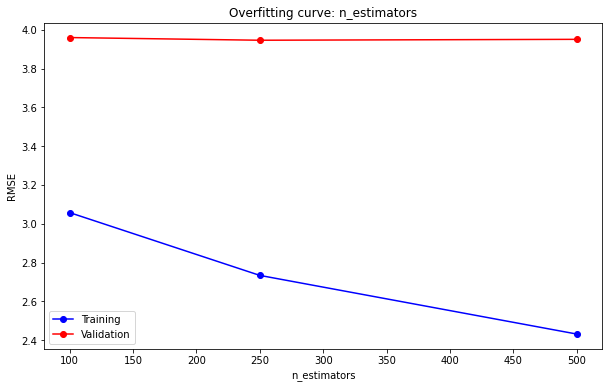

In [130]:
# train using different n_estimators and plot the training and validation error
%time 
test_param_and_plot(XGBRegressor, 'n_estimators', [100, 250, 500], **best_params)

Seems like 500 estimators has the lowest validation loss. However, it also takes a long time. Let's take 250 for now.

In [135]:
# set n_estimators to best value
best_params['n_estimators'] = 250

### Max Depth

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


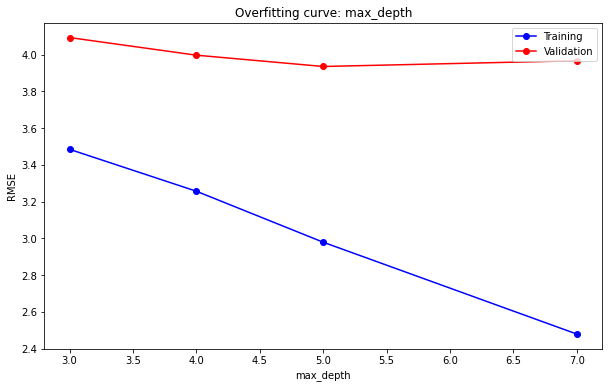

In [136]:
# train using different max_depth and plot the training and validation error
%time 
test_param_and_plot(XGBRegressor, 'max_depth', [3, 4, 5, 7], **best_params)

Looks like a max depth of 5 is ideal.

In [140]:
# set max_depth to best value
best_params['max_depth'] = 5

### Learning Rate

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 3.81 µs


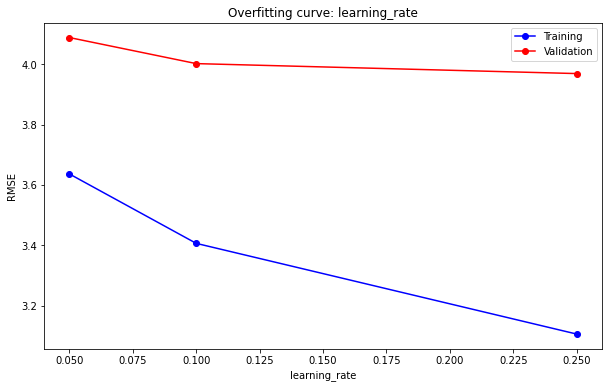

In [134]:
# train using different learning rates and plot the training and validation error
%time
test_param_and_plot(XGBRegressor, 'learning_rate', [0.05, 0.1, 0.25], **best_params)

Seems like the best learning rate is 0.25.

In [139]:
# set learning_rate to best value
best_params['learning_rate'] = 0.25

### Other Parameters

Similarly we can experiment with other parameters. 

Here's a set of parameters that works well:

In [137]:
# create final xgboost model object
xgb_model_final = XGBRegressor(objective='reg:squarederror', 
                               n_jobs=-1, 
                               random_state=42,
                               n_estimators=500, 
                               max_depth=8, 
                               learning_rate=0.08, 
                               subsample=0.8, 
                               colsample_bytree=0.8)

In [141]:
# fit the model on training set
%time
xgb_model_final.fit(train_inputs, train_targets)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 18.4 µs


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [142]:
# evaluate the model
evaluate(xgb_model_final)

(2.5186348,
 3.89185,
 array([ 6.5888057,  7.759765 ,  9.947111 , ..., 12.041484 ,  9.257844 ,
         9.980172 ], dtype=float32),
 array([15.513057,  5.671225, 47.584732, ...,  7.949226, 30.829145,
         8.740716], dtype=float32))

In [143]:
# predict on test set and generate submission file
predict_and_submit(xgb_model_final, 'xgb_tuned_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.840727
1,2015-01-27 13:08:24.0000003,10.699218
2,2011-10-08 11:53:44.0000002,4.877237
3,2012-12-01 21:12:12.0000002,9.198323
4,2012-12-01 21:12:12.0000003,15.848363
...,...,...
9909,2015-05-10 12:37:51.0000002,8.844397
9910,2015-01-12 17:05:51.0000001,11.517844
9911,2015-04-19 20:44:15.0000001,52.916367
9912,2015-01-31 01:05:19.0000005,18.823597


Acieved 460th position out of 1483 i.e. top 30%.

- We are using just 1% of the training data
- We are only using a single model (most top submissions use ensembles)
- Our best model takes just 10 minutes to train (as oppposed to hours/days)
- We haven't fully optimized the hyperparameters yet

Let's save the weights of this model. Follow this guide: https://scikit-learn.org/stable/modules/model_persistence.html

**Tasks**: 

1. Tune hyperparameters for Linear Regression & random forests.
2. Repeat with 3%, 10%, 30% and 100% of the training set. How much reduction in error does 100x more data produce?
3. Ensemble (average) the results from multiple models and observe if they're better than individual models.

### Save Outputs to Google Drive (Optional)

We can save all the output files we've created to Google Drive, so that we can reuse them later if required.

Guide: https://colab.research.google.com/notebooks/io.ipynb

## 9. Train on GPU with entire dataset (Optional)

Steps:
- Install `dask`, `cudf` and `cuml`
- Load the dataset to GPU
- Create training and validation set
- Perform feature engineering
- Train XGBoost `cuml` model
- Make predictions & submit

Guides:
- https://towardsdatascience.com/nyc-taxi-fare-prediction-605159aa9c24
- https://jovian.ai/allenkong221/nyc-taxi-fare-rapids-dask-gpu/v/1?utm_source=embed#C10

### Install `dask`, `cudf` and `cuml`

### Load the data

### Create training & validation set

### Perform feature engineering

### Train XGBoost model on GPU

### Make Predictions & Submit

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))